In [1]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel

In [2]:
model = AutoModel.from_pretrained("C:/Users/vhahoumowerj/.cache/huggingface/transformers/Bio_ClinicalBERT/")
tokenizer = AutoTokenizer.from_pretrained("C:/Users/vhahoumowerj/.cache/huggingface/transformers/Bio_ClinicalBERT/")

In [3]:
notes = pd.read_excel('P:/ORD_Singh_201911038D/Justin/InpatNote.xls')
retained_note_types = pd.read_csv("P:/ORD_Singh_201911038D/Justin/NoteTypes-adjudicated.csv")
retained_note_types = set(retained_note_types[retained_note_types['includeYN'] == 'y'].noteTitle.to_list())
retained_notes = notes[notes.TIUStandardTitle.isin(retained_note_types)]

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [4]:
#Prep some stats
print(f"Number of notes: {retained_notes.shape[0]} (of {notes.shape[0]} total records)")
print(f"Number of unique StudyIDs: {retained_notes.StudyID.unique().shape[0]}" + \
      f"(of {notes.StudyID.unique().shape[0]} total records)")
print("Retained notes: ", end='')
print(f"{retained_notes.ReportText.duplicated(keep=False).sum()} duplicate notes by text content, or" + \
      f" {retained_notes.ReportText.duplicated(keep='first').sum()} notes kept if selecting the first instance.")
print("Raw notes: ", end='')
print(f"{notes.ReportText.duplicated(keep=False).sum()} duplicate notes by text content, or" + \
      f" {notes.ReportText.duplicated(keep='first').sum()} notes kept if selecting the first instance.")
print(f"{retained_notes.TIUDocumentDefinition.unique().shape[0]} " + \
      f"(of {notes.TIUDocumentDefinition.unique().shape[0]}) unique note definition types.")
print(f"{retained_notes.TIUStandardTitle.unique().shape[0]} " +\
      f"(of {notes.TIUStandardTitle.unique().shape[0]}) unique note titles.")
print("Note definition types are usually more specific titles than the standard titles.")
print()
print("Words (by simple split) Statistics:")
print(pd.concat([retained_notes.ReportText.apply(lambda x: x.split()).apply(len).describe(), 
                 notes.ReportText.apply(lambda x: x.split()).apply(len).describe()], axis=1)\
                 .set_axis(['Retained Notes', 'Raw Notes'], axis=1, inplace=False))

Number of notes: 1647 (of 2730 total records)
Number of unique StudyIDs: 624(of 762 total records)
Retained notes: 303 duplicate notes by text content, or 159 notes kept if selecting the first instance.
Raw notes: 546 duplicate notes by text content, or 293 notes kept if selecting the first instance.
257 (of 513) unique note definition types.
65 (of 144) unique note titles.
Note definition types are usually more specific titles than the standard titles.

Words (by simple split) Statistics:
       Retained Notes    Raw Notes
count     1647.000000  2730.000000
mean       396.601700   364.684982
std        501.960965   433.527585
min          2.000000     2.000000
25%         31.000000    53.000000
50%        152.000000   204.000000
75%        616.000000   513.750000
max       3085.000000  3085.000000


In [5]:
tokenized_notes = tokenizer(retained_notes.ReportText.to_list())

In [6]:
tokenids = tokenized_notes['input_ids']
step = 512
overlap = 256
batchtokenids = []
for i in tokenids:
    if len(i) > 512:
        _ = [i[_:_+step] for _ in range(0, len(i)-overlap, step-overlap)]
    else:
        _ = [i]
    for ii, iii in enumerate(_):
        if len(iii) < 512:
            _[ii] = (iii+[0]*512)[:512]
    batchtokenids += [_]

In [ ]:
#Conversely, if you already have run it on the target notes, just laod them:
import pickle
with open('retainednotes_embeddings.pkl','rb') as infile:
    studynotes_embedded = pickle.load(infile)
studynotes_embedded = {study:np.average(notes, axis=0) for study, notes in studynotes_embedded.items()}
embedded_df = pd.DataFrame.from_dict(studynotes_embedded, orient='index')
embedded_df.head()

In [22]:
from sklearn.preprocessing import MinMaxScaler

#Load the old data set for which we have labels
structdf = pd.read_csv("./input/input.csv")
structdf = structdf.drop('smk_flags_man', axis=1)
structdf = structdf.drop('smk_flags_db', axis=1)
structdf = structdf[structdf.mod_label != 'INVALID']
print(f'Columns in df:\n{", ".join([x for x in structdf.columns])}')
label_column = 'mod_label'
feature_columns = list(structdf.columns)
feature_columns.remove(label_column)
feature_columns_cont = [
    'ed_inp_delta'
    ,'ed_duration'
    ,'elix_score'
    ,'age_val'
]
feature_columns_cat = [
    'img_flags'
    ,'con_flags'
]

structdf['ed_inp_delta'] = MinMaxScaler().fit_transform(structdf['ed_inp_delta'].values.reshape(-1,1))
structdf['ed_duration'] = MinMaxScaler().fit_transform(structdf['ed_duration'].values.reshape(-1,1))
structdf['elix_score'] = MinMaxScaler().fit_transform(structdf['elix_score'].values.reshape(-1,1))
structdf['age_val'] = MinMaxScaler().fit_transform(structdf['age_val'].values.reshape(-1,1))

studies_no_notes = [study for study in structdf.study_ids if study not in studynotes_embedded.keys()]
structdf_dropped = structdf.set_index('study_ids').drop(studies_no_notes)
embedded_df = structdf_dropped.join(embedded_df, how='inner')

Columns in df:
study_ids, ed_duration, ed_inp_delta, age_val, img_flags, con_flags, elix_score, mod_label


In [23]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.15
RANDOM_STATE_SEED = None

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

test_aucs = []
train_aucs = []
test_reports = []
train_reports = []
for i in range(100):
    eX_train, eX_test, ey_train, ey_test = train_test_split(embedded_df.drop(label_column, axis=1), \
                                                            embedded_df[label_column], \
                                                            test_size=TEST_SIZE, random_state=RANDOM_STATE_SEED)
    model = LogisticRegression(solver='liblinear', penalty='l2', C=20, max_iter=1000, fit_intercept = False)
    etest = eX_test.iloc[:,:]
    etrain = eX_train.iloc[:,:]
    model.fit(etrain, ey_train)
    test_probas  = model.predict_proba(etest)
    test_preds = model.predict(etest)
    train_preds = model.predict(etrain)
    train_probas = model.predict_proba(etrain)
    testauc = roc_auc_score(ey_test, test_probas[:,1])
    trainauc = roc_auc_score(ey_train, train_probas[:,1])
    test_aucs += [testauc]
    train_aucs += [trainauc]
    test_reports += [classification_report(ey_test, test_preds, output_dict=True)]
    train_reports += [classification_report(ey_train, train_preds, output_dict=True)]

print(f" Average Test AUC \u00B1 \u03C3 (100 iterations): " +\
      f"{np.average(test_aucs):0.3f} \u00B1 {np.std(test_aucs):0.3f}")
print(f"Average Train AUC \u00B1 \u03C3 (100 iterations): " +\
      f"{np.average(train_aucs):0.3f} \u00B1 {np.std(train_aucs):0.3f}")


 Average Test AUC ± σ (100 iterations): 0.656 ± 0.097
Average Train AUC ± σ (100 iterations): 0.977 ± 0.004


[0.76762463 0.13044726]
[0.49928436 0.17559552]


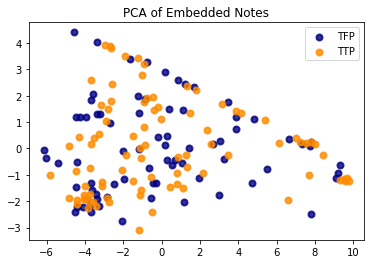

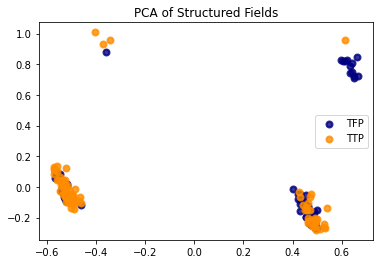

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pcadf = pca.fit(embedded_df.drop(label_column, axis=1).iloc[:,6:]).transform(embedded_df.drop(label_column, axis=1).iloc[:,6:])
print(pca.explained_variance_ratio_)
plt.figure()
colors = ['navy', 'darkorange']
lw = 2
for color, target in zip(colors, ['TFP', 'TTP']):
    plt.scatter(pcadf[embedded_df[label_column] == target][:,0], 
                pcadf[embedded_df[label_column] == target][:,1],
                color = color, alpha=0.8, lw=lw, label=target)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title("PCA of Embedded Notes")


pca = PCA(n_components=2)
pcadf = pca.fit(embedded_df.drop(label_column, axis=1).iloc[:,:6]).transform(embedded_df.drop(label_column, axis=1).iloc[:,:6])
print(pca.explained_variance_ratio_)
plt.figure()
colors = ['navy', 'darkorange']
lw = 2
for color, target in zip(colors, ['TFP', 'TTP']):
    plt.scatter(pcadf[embedded_df[label_column] == target][:,0], 
                pcadf[embedded_df[label_column] == target][:,1],
                color = color, alpha=0.8, lw=lw, label=target)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title("PCA of Structured Fields")

plt.show()

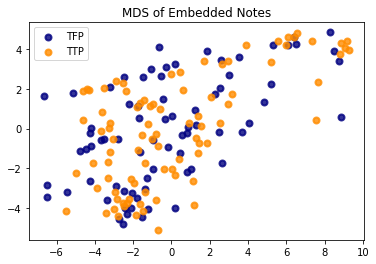

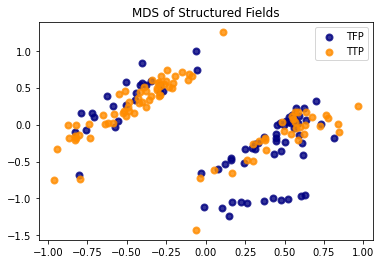

In [41]:
from sklearn.manifold import MDS

transformer = MDS(n_components=2)
trx = transformer.fit_transform(embedded_df.drop(label_column, axis=1).iloc[:,6:])

plt.figure()
colors = ['navy', 'darkorange']
lw = 2
for color, target in zip(colors, ['TFP', 'TTP']):
    plt.scatter(trx[embedded_df[label_column] == target][:,0], 
                trx[embedded_df[label_column] == target][:,1],
                color = color, alpha=0.8, lw=lw, label=target)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title("MDS of Embedded Notes")

transformer = MDS(n_components=2)
trx = transformer.fit_transform(embedded_df.drop(label_column, axis=1).iloc[:,:6])
plt.figure()
colors = ['navy', 'darkorange']
lw = 2
for color, target in zip(colors, ['TFP', 'TTP']):
    plt.scatter(trx[embedded_df[label_column] == target][:,0], 
                trx[embedded_df[label_column] == target][:,1],
                color = color, alpha=0.8, lw=lw, label=target)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title("MDS of Structured Fields")
plt.show()

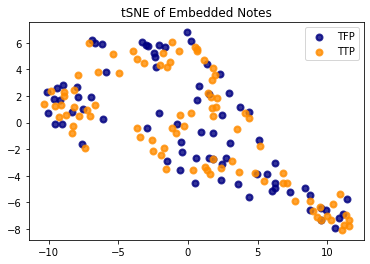

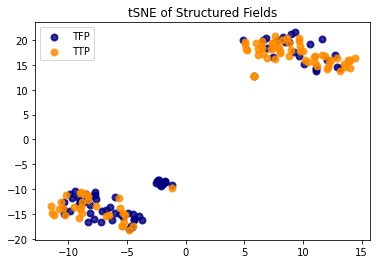

In [42]:
from sklearn.manifold import TSNE

transformer = TSNE(n_components=2)
trx = transformer.fit_transform(embedded_df.drop(label_column, axis=1).iloc[:,6:])

plt.figure()
colors = ['navy', 'darkorange']
lw = 2
for color, target in zip(colors, ['TFP', 'TTP']):
    plt.scatter(trx[embedded_df[label_column] == target][:,0], 
                trx[embedded_df[label_column] == target][:,1],
                color = color, alpha=0.8, lw=lw, label=target)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title("tSNE of Embedded Notes")

transformer = TSNE(n_components=2)
trx = transformer.fit_transform(embedded_df.drop(label_column, axis=1).iloc[:,:6])

plt.figure()
colors = ['navy', 'darkorange']
lw = 2
for color, target in zip(colors, ['TFP', 'TTP']):
    plt.scatter(trx[embedded_df[label_column] == target][:,0], 
                trx[embedded_df[label_column] == target][:,1],
                color = color, alpha=0.8, lw=lw, label=target)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title("tSNE of Structured Fields")
plt.show()

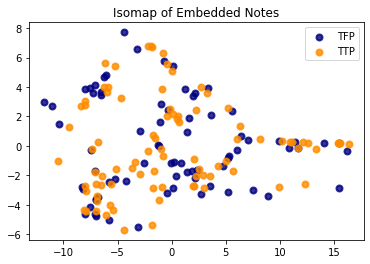

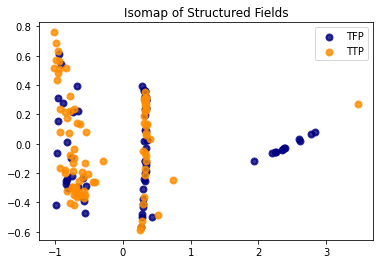

In [43]:
from sklearn.manifold import Isomap

transformer = Isomap(n_components=2)
trx = transformer.fit_transform(embedded_df.drop(label_column, axis=1).iloc[:,6:])

plt.figure()
colors = ['navy', 'darkorange']
lw = 2
for color, target in zip(colors, ['TFP', 'TTP']):
    plt.scatter(trx[embedded_df[label_column] == target][:,0], 
                trx[embedded_df[label_column] == target][:,1],
                color = color, alpha=0.8, lw=lw, label=target)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title("Isomap of Embedded Notes")

transformer = Isomap(n_components=2)
trx = transformer.fit_transform(embedded_df.drop(label_column, axis=1).iloc[:,:6])

plt.figure()
colors = ['navy', 'darkorange']
lw = 2
for color, target in zip(colors, ['TFP', 'TTP']):
    plt.scatter(trx[embedded_df[label_column] == target][:,0], 
                trx[embedded_df[label_column] == target][:,1],
                color = color, alpha=0.8, lw=lw, label=target)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title("Isomap of Structured Fields")
plt.show()